In [67]:
import tensorflow as tf
import numpy as np

In [68]:
file_path = './datas/prediction.csv'
def get_data(file_path):
    data = np.genfromtxt(file_path, delimiter=',', dtype="int", encoding=None)
    t = np.arange(0, len(data) * 0.1, 0.1)
    x = np.array(data[:, 0] / 1000)
    y = np.array(data[:, 1] / 1000)
    v = np.array(data[:, 2])
    return np.vstack((t, x, y, v)).T
active_data = get_data(file_path)  

# plot row data

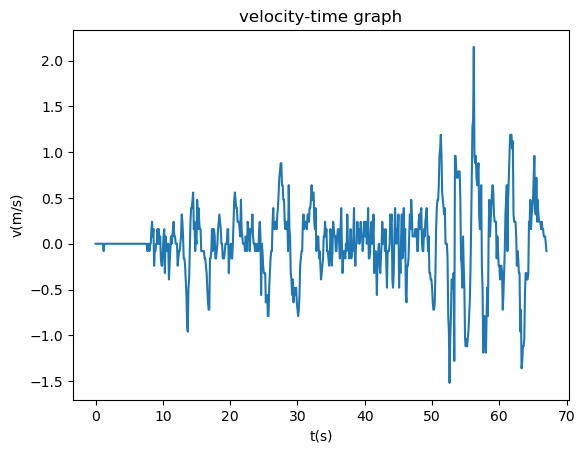

<Figure size 1500x600 with 0 Axes>

In [69]:
def plot_predict(data):
    import matplotlib.pyplot as plt
    plt.plot(data[:,0], data[:,3]/100)
    plt.xlabel('t(s)')
    plt.ylabel('v(m/s)')
    plt.title('velocity-time graph')
    plt.figure(figsize=(15, 6))
    plt.subplots_adjust(hspace=0.2, top=0.9)
    plt.show()
    
plot_predict(active_data)

# prepare data

In [70]:
WINDOW_SIZE = 25

velocity_row = active_data[:,3]

def sliding_window(data,size):
    start = 0
    while start< len(data):
        yield int(start), int(start + size)
        # start+= (size/2)
        start += size

def segment_signal(data,window_size = 25):
    segments = np.empty((0, window_size),dtype=float) 
    
    for (start, end) in sliding_window(range(len(data)), window_size):
        v = np.array(data[start:end])
        if len(v) == window_size:
            segments = np.vstack([segments, v])

    return segments     


velocity= segment_signal(velocity_row,WINDOW_SIZE)

print(velocity.shape)

(26, 25)


In [71]:
velocitys = velocity.reshape(velocity.shape + (1,))
print(velocitys.shape)

(26, 25, 1)


# make desicion

In [72]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_inferences):

  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_inferences),), dtype=int)
  print(input_details['dtype'])
  for i in range(len(test_inferences)):
    test_velocity = test_inferences[i]

    test_velocity = np.expand_dims(test_velocity, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_velocity)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


Netwrok = 'ResNet'
model_name = 'BA/v1'
prefix_path = f'./{Netwrok}/{model_name}'
tflite_file = prefix_path + '/quantized.tflite'
predictions = run_tflite_model(tflite_file,test_inferences=velocitys)
predictions


<class 'numpy.float32'>


array([0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 1, 3, 3, 4, 1, 1, 4, 4, 4,
       4, 4, 4, 4])

# display results

In [73]:
LABELS = [
    'Sitting',
    'Stretching',
    'Walking',
    'Jumping',
    'Running'
] 

def conv2Act(predictions):
    return [LABELS[i] for i in predictions]

activity = conv2Act(predictions)

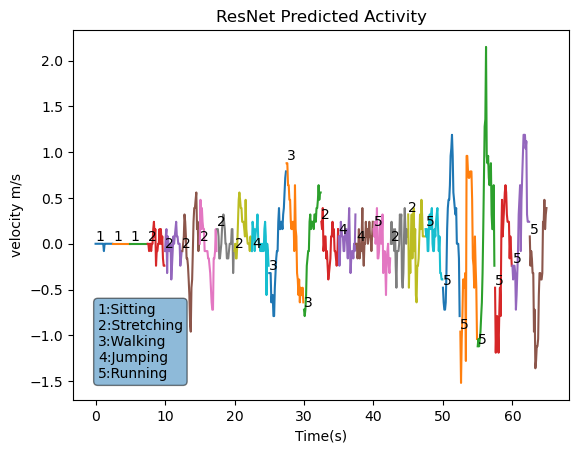

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


for i,velo in enumerate(velocity):
    x = np.arange(i*WINDOW_SIZE, i*WINDOW_SIZE + len(velo)) 
    ax.plot(x*0.1, velo/100) 
    ax.text(i*WINDOW_SIZE*0.1, velo[0]/100, f'{predictions[i]+1}', verticalalignment='bottom')


ax.set_title(f'{Netwrok} Predicted Activity')
ax.set_xlabel('Time(s)')
ax.set_ylabel('velocity m/s')

text = '\n'.join([f'{i + 1}:{LABELS[i]}' for i in range(len(LABELS))])
ax.text(0.05, 0.05, text, transform=ax.transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', alpha=0.5))

plt.show()
fig.savefig(prefix_path + '/prediction.png', dpi=300, bbox_inches='tight')